In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


Dataset downloaded at: /kaggle/input/creditcardfraud

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284

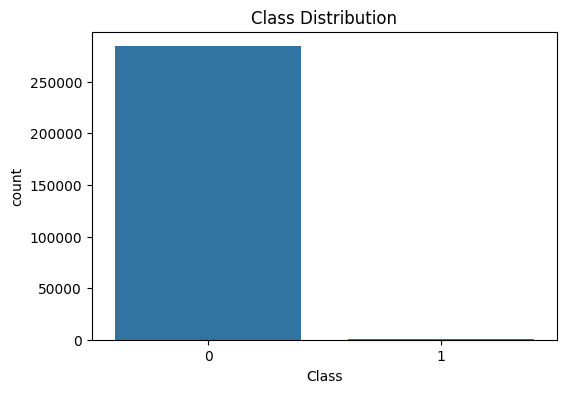

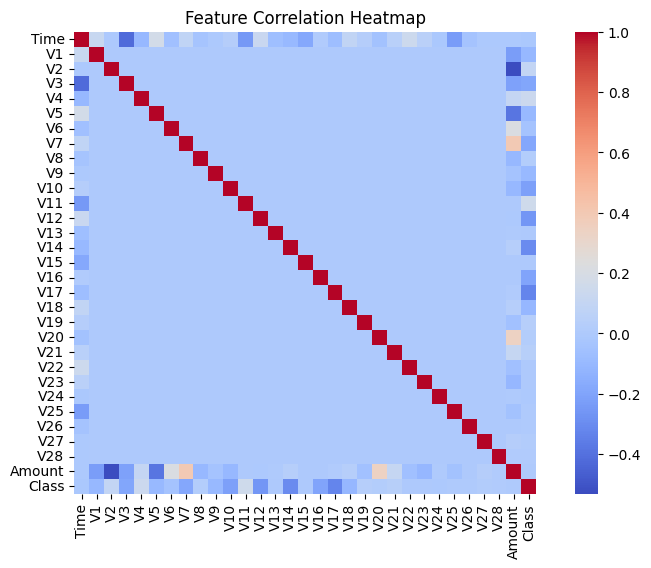


Resampled class distribution: Class
0    284315
1    284315
Name: count, dtype: int64

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     85295
           1       0.97      0.92      0.94     85294

    accuracy                           0.94    170589
   macro avg       0.95      0.94      0.94    170589
weighted avg       0.95      0.94      0.94    170589

ROC-AUC Score: 0.9894708766438332

=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       1.00      1.00      1.00     85294

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589

ROC-AUC Score: 0.9999996558834656
Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7398 - loss: 0.4794 - val_accuracy: 0.9497 - val_loss: 0.1159
Epoch 2/5
15

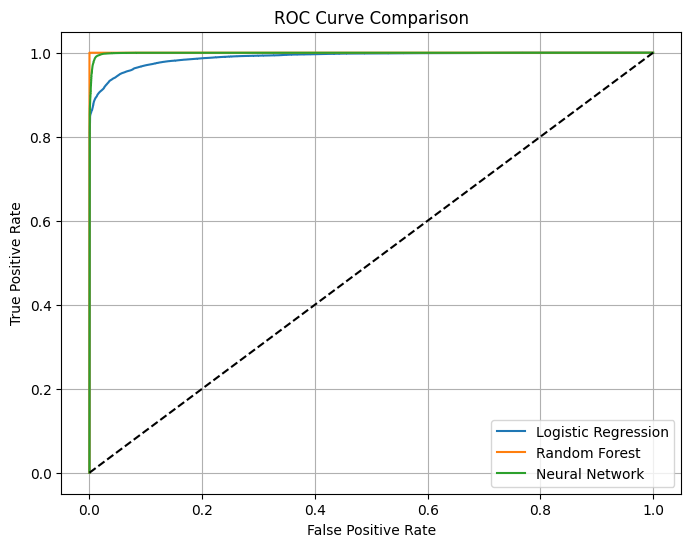

In [1]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.pipeline import Pipeline
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

# STEP 1: Download and load dataset
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Dataset downloaded at:", path)

df = pd.read_csv(os.path.join(path, "creditcard.csv"))

# STEP 2: EDA
print("\n--- Dataset Info ---")
print(df.info())
print("\n--- Summary Statistics ---")
print(df.describe())

print("\n--- Class Distribution ---")
print(df['Class'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Class')
plt.title("Class Distribution")
plt.show()

plt.figure(figsize=(10,6))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', vmax=1.0, square=True)
plt.title("Feature Correlation Heatmap")
plt.show()

# STEP 3: Data Preparation
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle Imbalance using SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)
print("\nResampled class distribution:", pd.Series(y_resampled).value_counts())

# STEP 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# STEP 5: Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:,1]

print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_lr))

# STEP 6: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_rf))

# STEP 7: Deep Learning - Neural Network
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=2048, validation_split=0.2, verbose=1)

# Evaluate NN
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
y_prob_dl = model.predict(X_test).flatten()
y_pred_dl = np.where(y_prob_dl > 0.5, 1, 0)

print("\n=== Deep Learning Model ===")
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred_dl))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_dl))

# STEP 8: Plot ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_dl, tpr_dl, _ = roc_curve(y_test, y_prob_dl)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_dl, tpr_dl, label='Neural Network')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()
